In [1]:
from pathlib import Path
from anndata import read_h5ad

import sys
import scanpy as sc
import os
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from scipy.stats import nbinom, pearsonr

from tqdm import tqdm

import pickle
import anndata as ad
from scipy.stats import zscore
from PIL import Image
from stimage._utils import gene_plot

In [2]:
from scipy import stats

def plot_correlation(df, attr_1, attr_2):
    r = stats.pearsonr(df[attr_1], 
                       df[attr_2])[0] **2

    g = sns.lmplot(data=df,
        x=attr_1, y=attr_2,
        height=5, legend=True
    )
    # g.set(ylim=(0, 360), xlim=(0,360))

    g.set_axis_labels(attr_1, attr_2)
    plt.annotate(r'$R^2:{0:.2f}$'.format(r),
                (max(df[attr_1])*0.9, max(df[attr_2])*0.9))
    return g


def calculate_correlation(attr_1, attr_2):
    r = stats.pearsonr(attr_1, 
                       attr_2)[0]
    return r

def calculate_correlation_2(attr_1, attr_2):
    r = stats.spearmanr(attr_1, 
                       attr_2)[0]
    return r

In [3]:
PATH_PRED = Path("/scratch/project_mnt/S0010/Xiao/Q1851/Xiao/Working_project/STimage_exp/Pete_Xenium")
PATH_GT = Path("/scratch/project_mnt/S0010/Xiao/Q1851/Xiao/Working_project/Pete/PROCESSED")
OUT_PATH = PATH_PRED / "PLOT"
OUT_PATH.mkdir(parents=True, exist_ok=True)

In [4]:
adata_dict = {}
for file_path in PATH_PRED.glob("./pred*.h5ad"):
    library_id = file_path.stem.split("_")[-1]
    adata = ad.read_h5ad(file_path)
    adata_dict[library_id] = adata

In [5]:
adata_dict

{'QMDL03': AnnData object with n_obs × n_vars = 5035 × 1522
     obs: 'imagecol', 'imagerow', 'n_cells', 'tile_tissue_mask_path', 'tissue_area', 'tile_path'
     uns: 'spatial'
     obsm: 'predicted_gene', 'spatial',
 'QMDL01': AnnData object with n_obs × n_vars = 3792 × 1522
     obs: 'imagecol', 'imagerow', 'n_cells', 'tile_tissue_mask_path', 'tissue_area', 'tile_path'
     uns: 'spatial'
     obsm: 'predicted_gene', 'spatial',
 'QMDL05': AnnData object with n_obs × n_vars = 2439 × 1522
     obs: 'imagecol', 'imagerow', 'n_cells', 'tile_tissue_mask_path', 'tissue_area', 'tile_path'
     uns: 'spatial'
     obsm: 'predicted_gene', 'spatial',
 'QMDL04': AnnData object with n_obs × n_vars = 554 × 1522
     obs: 'imagecol', 'imagerow', 'n_cells', 'tile_tissue_mask_path', 'tissue_area', 'tile_path'
     uns: 'spatial'
     obsm: 'predicted_gene', 'spatial',
 'QMDL02': AnnData object with n_obs × n_vars = 715 × 1522
     obs: 'imagecol', 'imagerow', 'n_cells', 'tile_tissue_mask_path', 'tis

In [21]:
adata_dict_gt = {}
gene_list=[]
for file_path in PATH_GT.glob("./grid_*.h5ad"):
    library_id = file_path.stem.split("_")[-1]
    adata = ad.read_h5ad(file_path)
    adata_dict_gt[library_id] = adata
    gene_list.append(adata.var_names.values.tolist())
gene_list = list(set([item for items in gene_list for item in items]))
with open(PATH_PRED / "xenium_gene_list.pkl", "wb") as f:
    pickle.dump(gene_list, f)

In [7]:
len(gene_list)

280

In [9]:
common_genes = list(set(gene_list) & set(adata_dict["QMDL04"].var_names))
len(common_genes)

106

In [9]:
OUT_PATH

PosixPath('/scratch/project_mnt/S0010/Xiao/Q1851/Xiao/Working_project/STimage_exp/Pete_Xenium/PLOT')

In [10]:
gene_to_plot = ['TIGIT', 'LTB', 'PTPRC', 'LILRA4', 'CD79A']

In [23]:
gene_to_plot = list(set(["CD163", "ESR1", "MS4A1", "BRCA2", "TP53", "ERBB2"]) & set(common_genes))
for library_id, adata in adata_dict.items():
    adata = adata[:, common_genes]
    adata.uns['spatial'][library_id]['scalefactors'] = {'tissue_hires_scalef': 0.1}
    hires = Image.fromarray(adata.uns["spatial"][library_id]["images"]["fulres"])
    hires.thumbnail((hires.size[0]//10, hires.size[1]//10))
    adata.uns["spatial"][library_id]["images"]["hires"] = hires
    adata.X = adata.to_df().apply(zscore)
    for gene in gene_to_plot:
        gene_plot(adata, genes=gene, image_scale=True, library_id=library_id, spot_size=50,
                        output=str(OUT_PATH), name=f"pred_{library_id}_{gene}.pdf")
        plt.close()

In [12]:
# hi-res image
gene_to_plot = list(set(["CD163", "ESR1", "MS4A1", "BRCA2", "TP53", "ERBB2"]) & set(common_genes))
for library_id, adata in adata_dict.items():
    adata = adata[:, common_genes]
    adata.uns['spatial'][library_id]['scalefactors'] = {'tissue_hires_scalef': 1}
    hires = Image.fromarray(adata.uns["spatial"][library_id]["images"]["fulres"])
    hires.thumbnail((hires.size[0], hires.size[1]))
    adata.uns["spatial"][library_id]["images"]["hires"] = hires
    adata.X = adata.to_df().apply(zscore)
    for gene in gene_to_plot:
        fig = gene_plot(adata, genes=gene, image_scale=True, library_id=library_id, spot_size=30)
        fig.savefig(OUT_PATH / f"hires_pred_{library_id}_{gene}.png", dpi=2000)
        plt.close()

In [11]:
# hi-res image 2
# gene_to_plot = list(set(["CD163", "ESR1", "MS4A1", "BRCA2", "TP53", "ERBB2"]) & set(common_genes))
for library_id, adata in adata_dict.items():
    adata = adata[:, common_genes]
    adata.uns['spatial'][library_id]['scalefactors'] = {'tissue_hires_scalef': 1}
    hires = Image.fromarray(adata.uns["spatial"][library_id]["images"]["fulres"])
    hires.thumbnail((hires.size[0], hires.size[1]))
    adata.uns["spatial"][library_id]["images"]["hires"] = hires
    adata.X = adata.to_df().apply(zscore)
    for gene in gene_to_plot:
        fig = gene_plot(adata, genes=gene, image_scale=True, library_id=library_id, spot_size=30)
        fig.savefig(OUT_PATH / f"hires_pred_{library_id}_{gene}.png", dpi=2000)
        plt.close()

In [24]:
for library_id, adata in adata_dict_gt.items():
    adata = adata[:, common_genes]
    adata.uns['spatial'][library_id]['scalefactors'] = {'tissue_hires_scalef': 0.1}
    hires = Image.fromarray(adata.uns["spatial"][library_id]["images"]["fulres"])
    hires.thumbnail((hires.size[0]//10, hires.size[1]//10))
    adata.uns["spatial"][library_id]["images"]["hires"] = hires
    adata.X = adata.to_df().apply(zscore)
    for gene in gene_to_plot:
        gene_plot(adata, genes=gene, image_scale=True, library_id=library_id, spot_size=50,
                        output=str(OUT_PATH), name=f"gt_{library_id}_{gene}.pdf")
        plt.close()

In [13]:
# hires
for library_id, adata in adata_dict_gt.items():
    adata = adata[:, common_genes]
    adata.uns['spatial'][library_id]['scalefactors'] = {'tissue_hires_scalef': 1}
    hires = Image.fromarray(adata.uns["spatial"][library_id]["images"]["fulres"])
    hires.thumbnail((hires.size[0], hires.size[1]))
    adata.uns["spatial"][library_id]["images"]["hires"] = hires
    adata.X = adata.to_df().apply(zscore)
    for gene in gene_to_plot:
        fig = gene_plot(adata, genes=gene, image_scale=True, library_id=library_id, spot_size=30)
        fig.savefig(OUT_PATH / f"hires_gt_{library_id}_{gene}.png", dpi=2000)
        plt.close()

In [12]:
# hires 2
for library_id, adata in adata_dict_gt.items():
    adata = adata[:, common_genes]
    adata.uns['spatial'][library_id]['scalefactors'] = {'tissue_hires_scalef': 1}
    hires = Image.fromarray(adata.uns["spatial"][library_id]["images"]["fulres"])
    hires.thumbnail((hires.size[0], hires.size[1]))
    adata.uns["spatial"][library_id]["images"]["hires"] = hires
    adata.X = adata.to_df().apply(zscore)
    for gene in gene_to_plot:
        fig = gene_plot(adata, genes=gene, image_scale=True, library_id=library_id, spot_size=30)
        fig.savefig(OUT_PATH / f"hires_gt_{library_id}_{gene}.png", dpi=2000)
        plt.close()

In [24]:
gene_to_plot = ["ESR1"]
for library_id, adata in adata_dict.items():
    if library_id == "QMDL03":
        adata = adata[:, common_genes]
        adata.uns['spatial'][library_id]['scalefactors'] = {'tissue_hires_scalef': 1}
        hires = Image.fromarray(adata.uns["spatial"][library_id]["images"]["fulres"])
        hires.thumbnail((hires.size[0], hires.size[1]))
        adata.uns["spatial"][library_id]["images"]["hires"] = hires
        adata.X = adata.to_df().apply(zscore,axis=0)
        for gene in gene_to_plot:
            fig = gene_plot(adata, genes=gene, image_scale=True, library_id=library_id, spot_size=30)
            fig.savefig(OUT_PATH / f"hires_pred_{library_id}_{gene}.png", dpi=2000)
            plt.close()

In [13]:
?gene_plot

Signature:
gene_plot(
    adata: anndata._core.anndata.AnnData,
    method: str = 'CumSum',
    slot: str = None,
    genes: Union[str, list, NoneType] = None,
    threshold: float = None,
    library_id: str = None,
    data_alpha: float = 1.0,
    tissue_alpha: float = 1.0,
    vmin: float = None,
    vmax: float = None,
    cmap: str = 'Spectral_r',
    spot_size: Union[float, int] = 6.5,
    show_legend: bool = False,
    show_color_bar: bool = True,
    show_axis: bool = False,
    cropped: bool = True,
    image_scale: bool = True,
    margin: int = 100,
    name: str = None,
    output: str = None,
) -> Union[matplotlib.backends.backend_agg.FigureCanvasAgg, NoneType]
Docstring:
Gene expression plot for spatial transcriptomics data.

Parameters
----------
adata : AnnData
    Annotated data matrix.
method : str, optional
    Use method to count. We provide: NaiveMean, NaiveSum, CumSum.
slot : str, optional
    Slot name in adata.obsm.
genes : str or list, optional
    Choose a gen

In [14]:
OUT_PATH

PosixPath('/scratch/project_mnt/S0010/Xiao/Q1851/Xiao/Working_project/STimage_exp/Pete_Xenium/PLOT')

In [11]:
# from stimage2.datasets.Xenium_dataset import Blake_xenium, Pfizer_xenium
# from pathlib import Path
# import pickle
# gene_list = []
# for i in range(len(sdataset)):
#     sdata = sdataset.load_data(i)
#     gene_list.append(sdata["table"].var_names.values.tolist())
# gene_list = list(set([item for items in gene_list for item in items]))
# with open(PATH_PRED / "xenium_gene_list.pkl", "wb") as f:
#     pickle.dump(gene_list, f)

In [13]:
df = pd.DataFrame()
for library_id, adata_gt in adata_dict_gt.items():
    print(library_id)
    adata_pred = adata_dict[library_id]
    common_spots = list(set(adata_gt.obs_names) & set(adata_pred.obs_names))
    adata_gt = adata_gt[common_spots, common_genes]
    adata_pred = adata_pred[common_spots, common_genes]
    for gene in common_genes:
        cor_val = calculate_correlation(adata_gt.to_df().loc[:,gene], adata_pred.to_df().loc[:,gene])
        df = pd.concat([df, pd.DataFrame([gene, cor_val, library_id, "STimage_Pete"],
                            index=["Gene", "Pearson correlation", "Slide", "Method"]).transpose()], ignore_index=True, axis=0)
    

QMDL02
QMDL05
QMDL01
QMDL03
QMDL04


In [14]:
df

,Gene,Pearson correlation,Slide,Method
0,FCER1G,-0.100487,QMDL02,STimage_Pete
1,CD79B,0.02282,QMDL02,STimage_Pete
2,CXCL16,-0.165957,QMDL02,STimage_Pete
3,MMP12,0.161513,QMDL02,STimage_Pete
4,CD80,-0.030893,QMDL02,STimage_Pete
...,...,...,...,...
525,NKG7,0.065415,QMDL04,STimage_Pete
526,PIM1,0.029094,QMDL04,STimage_Pete
527,S100A8,-0.028905,QMDL04,STimage_Pete
528,IGF1,-0.020736,QMDL04,STimage_Pete


In [18]:
top_100gene = df.groupby("Gene")["Pearson correlation"].mean().sort_values(ascending=False)[0:100].index
df_top100 = df[df["Gene"].isin(top_100gene)]

In [22]:
df_top100.sort_values(by="Pearson correlation", ascending=False)["Gene"].values

array(['TIGIT', 'LTB', 'PTPRC', 'LILRA4', 'CD79A', 'AR', 'SLAMF7', 'CD86',
       'PRF1', 'KLRD1', 'MS4A1', 'PTPRC', 'CD4', 'TRAC', 'AR', 'PRF1',
       'SLAMF7', 'CCL5', 'PGR', 'PIM1', 'CCND1', 'AR', 'CD8A', 'AR', 'AR',
       'C1QA', 'TCF7', 'FOXA1', 'CCND1', 'CXCL12', 'KLRB1', 'NKG7',
       'HAVCR2', 'PRDM1', 'LILRA4', 'ERBB2', 'IL2RG', 'PDCD1LG2', 'RORC',
       'PDCD1LG2', 'FOXA1', 'PIM1', 'LY86', 'CCL5', 'TCF7', 'RORC',
       'ESR1', 'KLRD1', 'CCL5', 'GNLY', 'IL2RG', 'GZMA', 'TIGIT', 'ESR1',
       'TCF4', 'GATA3', 'CCND1', 'CXCR4', 'CD9', 'MDM2', 'ESR1', 'RORC',
       'ERBB2', 'ITGAX', 'CD14', 'CD8A', 'CD163', 'GZMA', 'ADGRE5',
       'CCL5', 'LTB', 'PPARG', 'KLRB1', 'TCF7', 'CD79A', 'GATA3', 'ITGAM',
       'CD3E', 'CD27', 'NKG7', 'CD3E', 'FOXA1', 'KIT', 'RUNX1', 'SLAMF7',
       'EIF4EBP1', 'CD86', 'RUNX1', 'PDGFRB', 'GATA3', 'PDGFRA', 'PGR',
       'FOXA1', 'RORC', 'SFRP4', 'KIT', 'PECAM1', 'IL2RA', 'SOX17',
       'CDH1', 'FCER1G', 'TIGIT', 'KLRB1', 'CD27', 'KLRD1', 'RUNX

In [15]:
df.to_csv(OUT_PATH / "correlation.csv")

In [23]:
ax, fig = plt.subplots(figsize=(10,6))
sns.boxplot(x="Slide", y="Pearson correlation", data=df_top100)
# plt.ylim(0,1)
plt.savefig(OUT_PATH / "top_100gene.pdf")

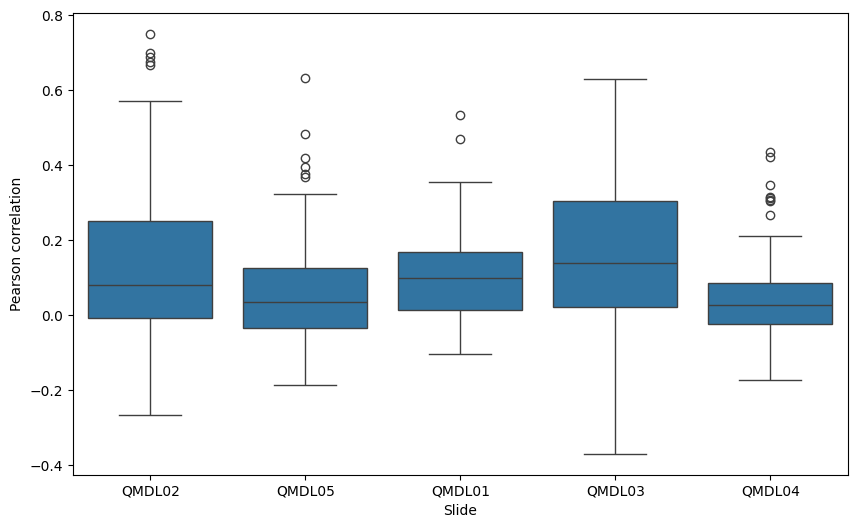

In [24]:
plt.show()